In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/pufr_fixed_jetME/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_origin_sig = f["jet_origin"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("ntuples/pufr_fixed_jetME/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_origin_bkg = f["jet_origin"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

In [3]:
class Jet:
    """
    The Jet object contains the features of each jet at the event level.
    It also has many useful methods to assist with data processing.
    """
    def __init__(self, feats):
        pt, eta, phi, m, pufr, label, origin = feats
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.m = m
        self.pufr = pufr
        self.label = label
        self.origin = origin
        
    def __len__(self):
        return len(self.pt)
        
    def apply_mask(self, mask):
        self.pt = self.pt[mask]
        self.eta = self.eta[mask]
        self.phi = self.phi[mask]
        self.m = self.m[mask]
        self.pufr = self.pufr[mask]
        self.label = self.label[mask]
        self.origin = self.origin[mask]
        
    def return_event_idx(self):
        sig = (self.label==1)
        sig_event = ak.mean(sig,axis=1)==1
        bkg_event = ak.mean(sig,axis=1)==0
        return sig_event,bkg_event
    
    def return_mean(self):
        return [ak.mean(self.pt), ak.mean(self.eta), ak.mean(self.phi), ak.mean(self.m)]
    
    def return_std(self):
        return [ak.std(self.pt), ak.std(self.eta), ak.std(self.phi), ak.std(self.m)]
    
    def apply_norm(self,mean_list,std_list):
        self.pt = (self.pt-mean_list[0]) / std_list[0]
        self.eta = (self.eta-mean_list[1]) / std_list[1]
        self.phi = (self.phi-mean_list[2]) / std_list[2]
        self.m = (self.m-mean_list[3]) / std_list[3]
        
    def return_subset(self, start_idx, stop_idx):
        pt = self.pt[start_idx:stop_idx]
        eta = self.eta[start_idx:stop_idx]
        phi = self.phi[start_idx:stop_idx]
        m = self.m[start_idx:stop_idx]
        pufr = self.pufr[start_idx:stop_idx]
        label = self.label[start_idx:stop_idx]
        origin = self.origin[start_idx:stop_idx]
        feats = [pt,eta,phi,m,pufr,label,origin]
        return Jet(feats)
    
    def return_dataset(self):
        data = ak.concatenate([self.pt[:,:,np.newaxis],self.eta[:,:,np.newaxis],self.phi[:,:,np.newaxis],self.m[:,:,np.newaxis]], axis=2)
        labels = ak.mean(self.label,axis=1)
        #data = torch.nested.nested_tensor(ak.to_list(data))
        #labels = torch.Tensor(labels).reshape(-1,1)
        return data, [labels, self.origin]
    
    def one_hot_encode_origin(self):
        origin = ak.to_list(self.origin)
        unique_labels = np.unique(ak.flatten(origin))
        label_dict = {}
        one_hot_label = np.zeros(len(unique_labels))
        for i, label in enumerate(unique_labels):
            one_hot_label = np.zeros(len(unique_labels))
            one_hot_label[i] = 1
            label_dict[label] = one_hot_label   
        num_events = len(origin)
        for i in range(num_events):
            num_jets = len(origin[i])
            for j in range(num_jets):
                origin[i][j] = label_dict[origin[i][j]]
        self.origin = ak.Array(origin)

In [4]:
# Construct list of features
feats_sig = [jet_pt_sig, jet_eta_sig, jet_phi_sig, jet_m_sig, jet_pufr_sig, jet_label_sig, jet_origin_sig]
feats_bkg = [jet_pt_bkg, jet_eta_bkg, jet_phi_bkg, jet_m_bkg, jet_pufr_bkg, jet_label_bkg, jet_origin_bkg]

# Combined Signal and Background
feats = []
for i in range(len(feats_sig)):
    feats.append(ak.concatenate([feats_sig[i],feats_bkg[i]], axis=0))
    
# Initialize Jet object and pass features
jets = Jet(feats)

# Print features
print(jets.pt)
print(jets.eta)
print(jets.phi)
print(jets.m)
print(jets.pufr)
print(jets.label)
print(jets.origin)

[[228, 172, 117, 98.6, 84.6, 47.1, ..., 26.7, 26.4, 25.8, 25.8, 25.5], ...]
[[-1.18, 1.31, 0.943, -1.1, 0.682, ..., -2.4, 3.03, -3.3, 1.94, 1.83], ...]
[[2.05, 4.71, 5.34, 1.46, 6.11, 3.81, ..., 2.23, 1.86, 4.27, 5.31, 0.443], ...]
[[50.4, 35.5, 31.4, 27.7, 22.9, 27.7, ..., 14.6, 14.4, 10.3, 14.7, 14.4], ...]
[[0.0379, 0.00049, 0.0966, 0.00467, 0.0275, ..., 0.345, 1, 0.949, 1], ...]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ...]
[[24, -24, -24, 24, 6, -1, -1, 6, -1, ..., 6, 6, -1, -1, -1, -1, -1, -1], ...]


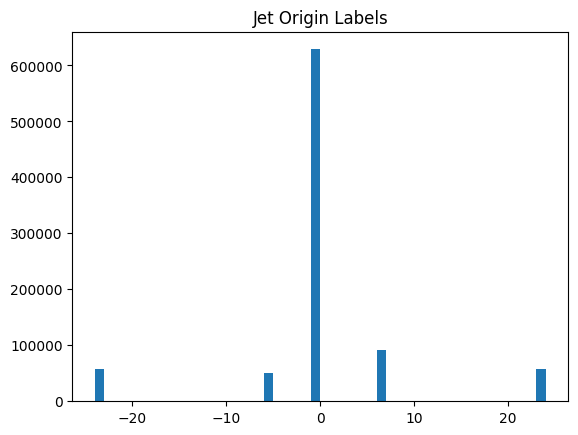

In [5]:
# Plot Origin Labels
plt.hist(ak.flatten(jets.origin), bins=48)
plt.title("Jet Origin Labels")
plt.show()

# Convert labels to one-hot encoded vectors
jets.one_hot_encode_origin()

In [6]:
# Shuffle the events
shuffled_idx = np.random.permutation(len(jets))
jets.apply_mask(shuffled_idx)

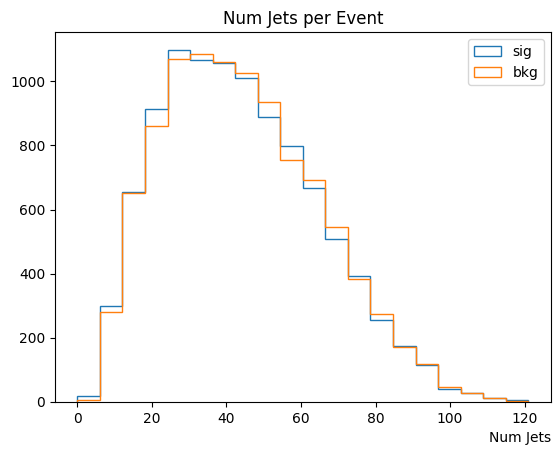

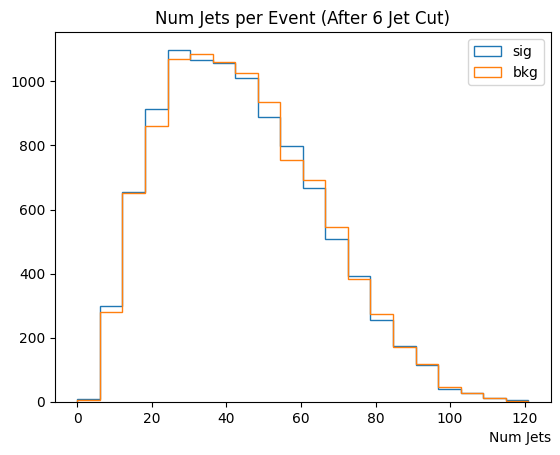

In [7]:
# Plot number of jets per event
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

# Require at least six jets
mask = h_num_jets>=6
jets.apply_mask(mask)
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event (After 6 Jet Cut)')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

In [8]:
def test_val_train_split(Jets):
    num_events = len(Jets)
    train_split = int(0.7*num_events)
    test_split = int(0.75*num_events)
    
    X_train = Jets.return_subset(0,train_split)
    X_val = Jets.return_subset(train_split,test_split)
    X_test = Jets.return_subset(test_split,num_events)
    
    mean_list = X_train.return_mean()
    std_list = X_train.return_std()
    
    X_train.apply_norm(mean_list, std_list)
    X_val.apply_norm(mean_list, std_list)
    X_test.apply_norm(mean_list, std_list)
    
    X_train, y_train = X_train.return_dataset()
    X_val, y_val = X_val.return_dataset()
    X_test, y_test = X_test.return_dataset()
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = test_val_train_split(jets)

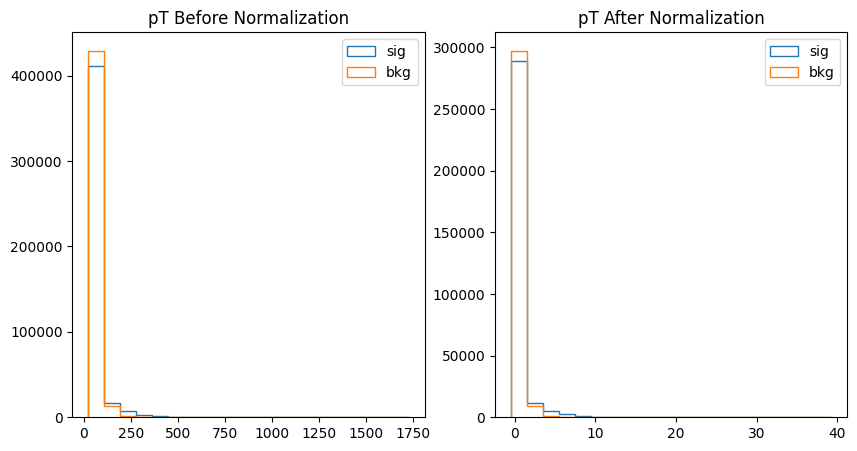

Before Mean:  44.96555102556809
Before STD:  42.64007263490457
After Mean:  -0.00023529166798927053
After STD:  1.000182010262095


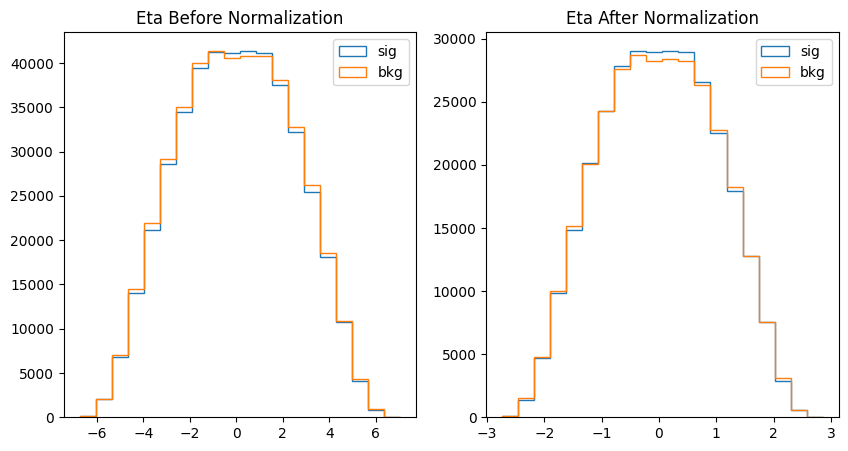

Before Mean:  -0.001279100112561276
Before STD:  2.466722873302103
After Mean:  5.1029496139628616e-08
After STD:  1.0000843238048982


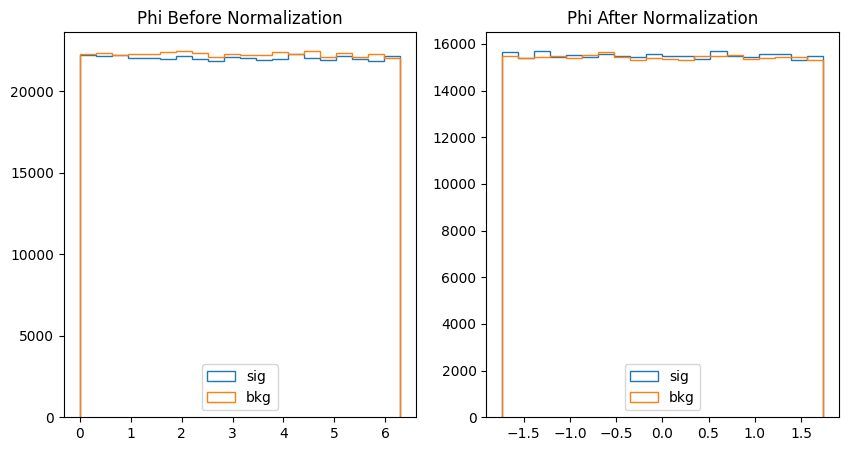

Before Mean:  3.138396384437913
Before STD:  1.812719609809242
After Mean:  2.8251374823418e-05
After STD:  1.0002596209361359


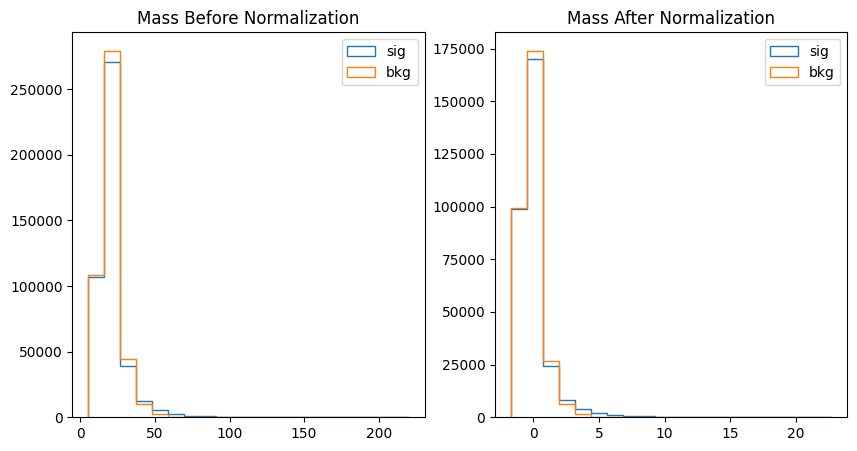

Before Mean:  20.958810223624862
Before STD:  8.732734559437127
After Mean:  -3.356611804763685e-06
After STD:  1.0000618967287622


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [9]:
# Validation plots
var_list = ['pT','Eta','Phi','Mass']
var_list_before = [jets.pt,jets.eta,jets.phi,jets.m]
var_list_after = [X_train[:,:,0],X_train[:,:,1],X_train[:,:,2],X_train[:,:,3]]

for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = var_list_before[i]
    mini=ak.min(var1)
    maxi=ak.max(var1)
    sig,bkg = jets.return_event_idx()
    ax1.hist(ak.ravel(var1[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax1.hist(ak.ravel(var1[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = var_list_after[i]
    mini=ak.min(var2)
    maxi=ak.max(var2)
    sig = (y_train[0]==1)
    bkg = ~sig
    ax2.hist(ak.ravel(var2[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax2.hist(ak.ravel(var2[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.nested.nested_tensor(ak.to_list(X_train))
label_train = torch.Tensor(y_train[0]).reshape(-1,1)
origin_train = torch.nested.nested_tensor(ak.to_list(y_train[1]))

X_val = torch.nested.nested_tensor(ak.to_list(X_val))
label_val = torch.Tensor(y_val[0]).reshape(-1,1)
origin_val = torch.nested.nested_tensor(ak.to_list(y_val[1]))

X_test = torch.nested.nested_tensor(ak.to_list(X_test))
label_test = torch.Tensor(y_test[0]).reshape(-1,1)
origin_test = torch.nested.nested_tensor(ak.to_list(y_test[1]))

In [10]:
class Baseline(nn.Module):
    def __init__(self, in_feats, hidden_feats, label_classes):
        super(Baseline, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_label = nn.Linear(hidden_feats,label_classes)
    def forward(self, jet_feats):
        # Preprocess Jet Features using dimensional expansion
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))

        # Aggregate Jets to form Event Embedding
        jet_aggregated = jet_embedding.sum(dim=0)
        label = F.sigmoid(self.jet_label(jet_aggregated))
        return label

In [11]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, origin_classes, label_classes):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_origin = nn.Linear(hidden_feats,origin_classes)
        self.jet_label = nn.Linear(hidden_feats+origin_classes,label_classes)
    def forward(self, jet_feats):
        # Preprocess Jet Features using dimensional expansion
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        
        # Get origin prediction using jet_embedding
        origin = F.softmax(self.jet_origin(jet_embedding),dim=1)
        jet_embedding = torch.cat((jet_embedding, origin), dim=1)

        # Aggregate Jets to form Event Embedding
        jet_aggregated = jet_embedding.sum(dim=0)
        label = F.sigmoid(self.jet_label(jet_aggregated))
        return label, origin

In [12]:
def train(model, data, alpha, beta, epochs=20):
    X_train, label_train, origin_train, X_val, label_val, origin_val = data
    
    history = {'train_loss':[],'val_loss':[],'train_BCE':[],'train_CCE':[],'val_BCE':[],'val_CCE':[],}
    
    for e in range(epochs): 
        cum_loss_train = []
        cum_loss_val = []
        cum_train_BCE = []
        cum_train_CCE = []
        cum_val_BCE = []
        cum_val_CCE = []
        
        train_pred = []
        acc_train = []
        
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            combined=False
            optimizer.zero_grad()
            try:
                label, origin = model(X_train[event].to(device))
                BCE = BCE_loss(label, label_train[event].to(device))
                target = torch.argmax(origin_train[event], dim=1).to(device)
                CCE = CCE_loss(origin, target)
                loss = BCE * alpha + CCE * beta
                cum_train_BCE.append(BCE.detach().cpu().numpy())
                cum_train_CCE.append(CCE.detach().cpu().numpy())
                combined=True
            except:
                label = model(X_train[event].to(device))
                loss = BCE_loss(label, label_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
            train_pred.append(label.detach().cpu().numpy())
            
        train_pred = np.array(train_pred) > 0.5
        acc_train.append(accuracy_score(label_train, train_pred))
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            try:
                label, origin = model(X_val[event].to(device))
                BCE = BCE_loss(label, label_val[event].to(device))
                target = torch.argmax(origin_val[event], dim=1).to(device)
                CCE = CCE_loss(origin, target)
                loss = BCE * alpha + CCE * beta
                cum_val_BCE.append(BCE.detach().cpu().numpy())
                cum_val_CCE.append(CCE.detach().cpu().numpy())
            except:
                label = model(X_val[event].to(device))
                loss = BCE_loss(label, label_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['val_loss'].append(np.mean(cum_loss_val))
        if combined:
            history['train_BCE'].append(np.mean(cum_train_BCE))
            history['train_CCE'].append(np.mean(cum_train_CCE))
            history['val_BCE'].append(np.mean(cum_val_BCE))
            history['val_CCE'].append(np.mean(cum_val_CCE))

        if (e+1)%1==0:
            print('Epoch:',e+1,
                  '\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),
                  '\tVal Loss:',round(float(np.mean(cum_loss_val)),4), 
                  '\tTrain Binary Accuracy:',round(acc_train[-1],4))

    return history   

In [13]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training Baseline
Epoch: 1 	Train Loss: 0.5791 	Val Loss: 0.5569 	Train Binary Accuracy: 0.7111
Epoch: 2 	Train Loss: 0.5384 	Val Loss: 0.5536 	Train Binary Accuracy: 0.7529
Epoch: 3 	Train Loss: 0.5404 	Val Loss: 0.5521 	Train Binary Accuracy: 0.7564
Epoch: 4 	Train Loss: 0.5382 	Val Loss: 0.5512 	Train Binary Accuracy: 0.758
Epoch: 5 	Train Loss: 0.5369 	Val Loss: 0.5506 	Train Binary Accuracy: 0.7586
Epoch: 6 	Train Loss: 0.536 	Val Loss: 0.5502 	Train Binary Accuracy: 0.7582
Epoch: 7 	Train Loss: 0.5353 	Val Loss: 0.5498 	Train Binary Accuracy: 0.758
Epoch: 8 	Train Loss: 0.5348 	Val Loss: 0.5494 	Train Binary Accuracy: 0.7582
Epoch: 9 	Train Loss: 0.5344 	Val Loss: 0.5491 	Train Binary Accuracy: 0.7585
Epoch: 10 	Train Loss: 0.534 	Val Loss: 0.5489 	Train Binary Accuracy: 0.7585
Epoch: 11 	Train Loss: 0.5337 	Val Loss: 0.5487 	Train Binary Accuracy: 0.759
Epoch: 12 	Train Loss: 0.5334 	Val Loss: 0.5484 	Train Binary Accuracy: 0.7594
Epoch: 13 	Train Loss: 0.5332 	Val Loss: 0.5483 

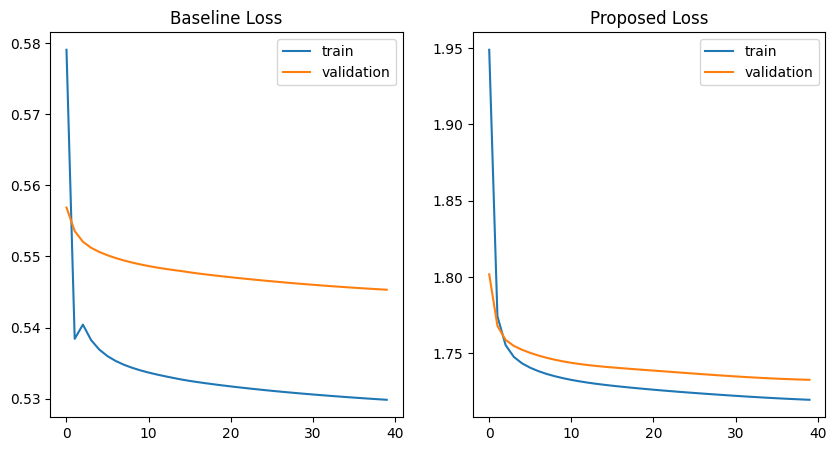

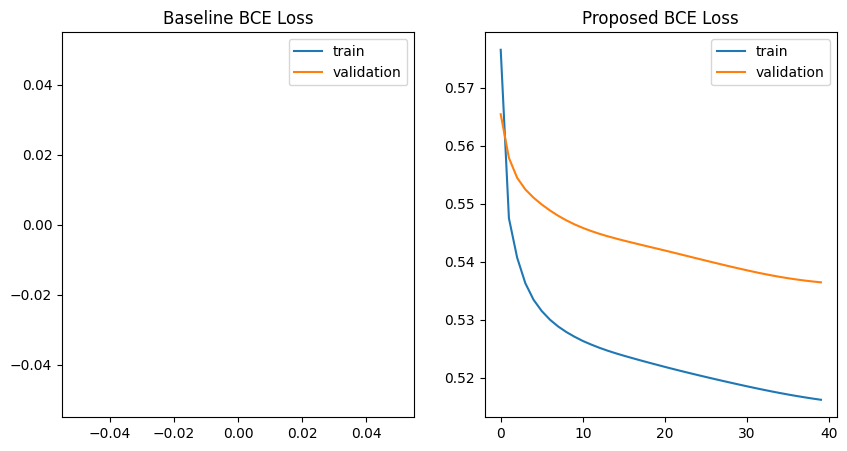

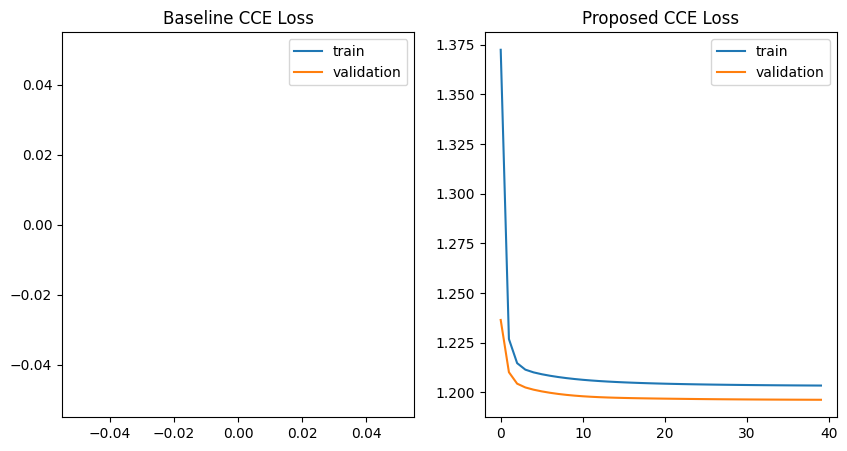

In [14]:
# Use BinaryCrossEntropy for binary classification
BCE_loss = nn.BCELoss()
CCE_loss = nn.CrossEntropyLoss()

data = [X_train, label_train, origin_train, X_val, label_val, origin_val]

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Baseline(4,32,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.0001)

alpha = 1
beta = 0
baseline_history = train(baseline, data, alpha, beta, epochs=40)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Proposed")
model = Model(4,32,5,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

alpha = 1
beta = 1
model_history = train(model, data, alpha, beta, epochs=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['val_loss'],label='validation')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['val_loss'],label='validation')
ax2.set_title("Proposed Loss")
ax2.legend()
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_BCE'],label='train')
ax1.plot(baseline_history['val_BCE'],label='validation')
ax1.set_title("Baseline BCE Loss")
ax1.legend()
ax2.plot(model_history['train_BCE'],label='train')
ax2.plot(model_history['val_BCE'],label='validation')
ax2.set_title("Proposed BCE Loss")
ax2.legend()
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_CCE'],label='train')
ax1.plot(baseline_history['val_CCE'],label='validation')
ax1.set_title("Baseline CCE Loss")
ax1.legend()
ax2.plot(model_history['train_CCE'],label='train')
ax2.plot(model_history['val_CCE'],label='validation')
ax2.set_title("Proposed CCE Loss")
ax2.legend()
plt.show()

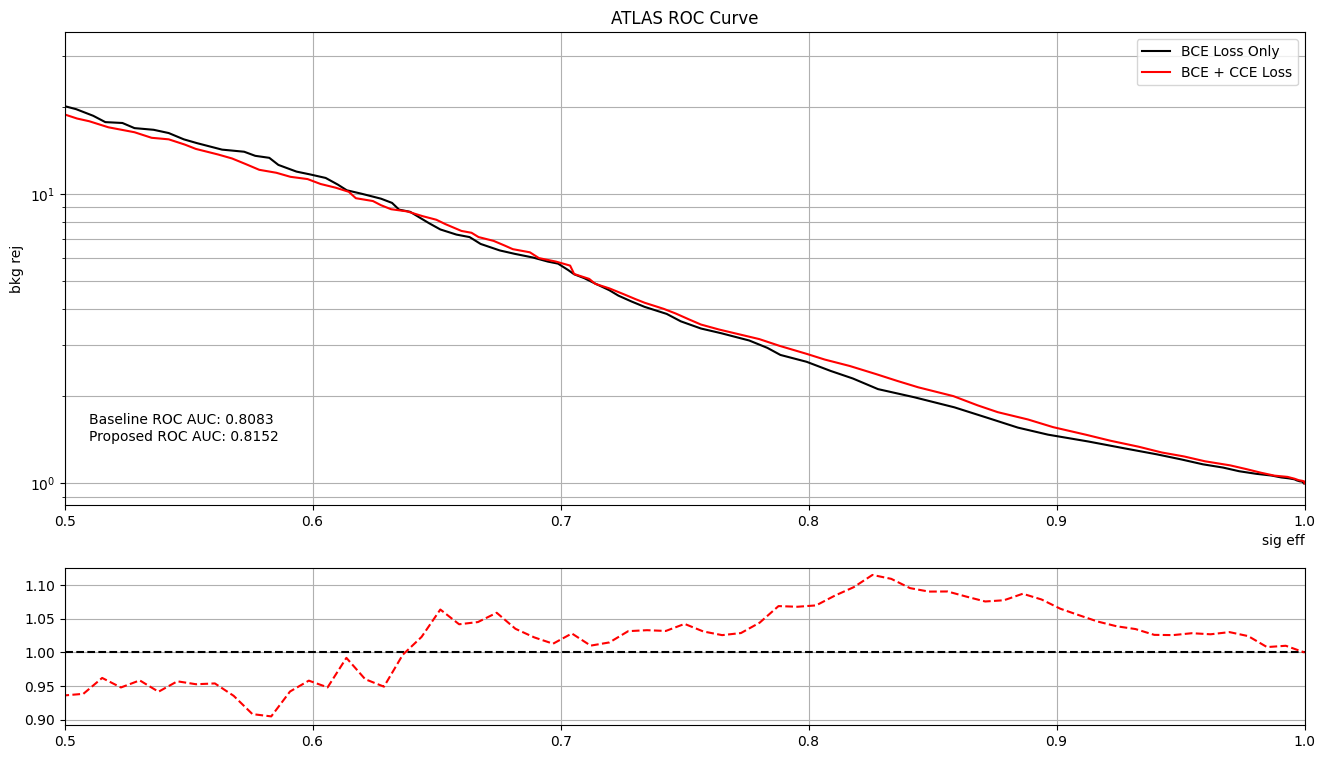

In [15]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.75,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum()  / y_true[bkg].shape[0]))

        #print("Theshold: ", threshold)
        #print("Signal Efficiency: ", sig_eff[-1])
        #print("Background Efficiency: ", bkg_eff[-1],"\n")
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

num_test = X_test.size(0)

# Plot Baseline ATLAS ROC
baseline.to(device)
baseline.eval()
label_pred_baseline = []
origin_pred_baseline = []
for event in range(num_test):
    l_pred = baseline(X_test[event].to(device))
    label_pred_baseline.append(l_pred.detach().cpu().numpy())
    #origin_pred_baseline.append(o_pred.detach().cpu().numpy())
label_pred_baseline = np.array(label_pred_baseline)
x1,y1, thresholds = ATLAS_roc(label_test, label_pred_baseline)
ax1.plot(x1,y1, label="BCE Loss Only",color='k')
AUC = "Baseline ROC AUC: " + str(round(roc_auc_score(label_test, label_pred_baseline),4))
ax1.text(0.51,1.6,AUC)

# Plot Proposed ATLAS ROC
model.to(device)
model.eval()
label_pred_proposed = []
origin_pred_proposed = []
for event in range(num_test):
    l_pred, o_pred = model(X_test[event].to(device))
    label_pred_proposed.append(l_pred.detach().cpu().numpy())
    origin_pred_proposed.append(o_pred.detach().cpu().numpy())
label_pred_proposed = np.array(label_pred_proposed)
x2,y2, thresholds = ATLAS_roc(label_test, label_pred_proposed)
ax1.plot(x2,y2, label="BCE + CCE Loss",color='r')
ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")
AUC = "Proposed ROC AUC: " + str(round(roc_auc_score(label_test, label_pred_proposed),4))
ax1.text(0.51,1.4,AUC)

# Plot ratio plot
x = 1-np.flip(thresholds)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x1),np.flip(y1))
ax2.plot(x,ratio1,linestyle='--',color='k')
ax2.plot(x,ratio2,linestyle='--',color='r')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.5,1)
ax2.set_xlim(0.5,1)
plt.show()

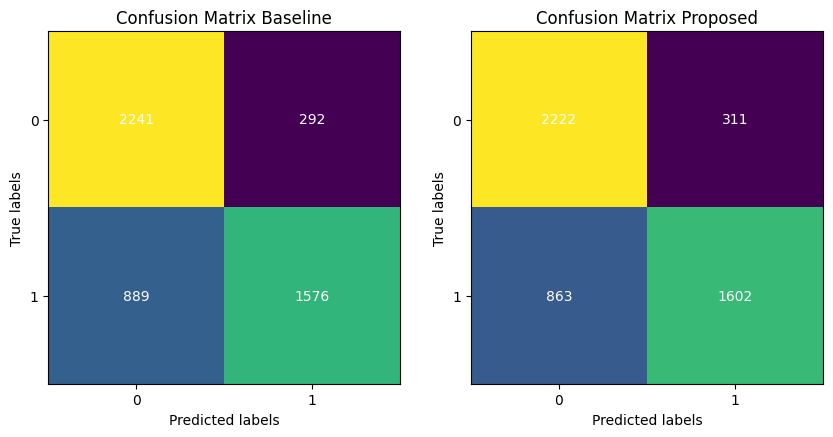

Binary Accuracy of Baseline:  0.7637054821928771
Binary Accuracy of Proposed:  0.7651060424169668

F1 Score of Baseline:  0.7274405723517193
F1 Score of Proposed:  0.7318410232983097


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

threshold = 0.5

label_Pred_proposed = label_pred_proposed > threshold
label_Pred_baseline = label_pred_baseline > threshold

cm =confusion_matrix(label_test, label_Pred_baseline)
ax1.imshow(cm)
ax1.set_title("Confusion Matrix Baseline")
#ax1.set_colorbar()
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax1.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")

cm =confusion_matrix(label_test, label_Pred_proposed)
ax2.imshow(cm)
ax2.set_title("Confusion Matrix Proposed")
#ax2.colorbar()
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
for i in range(len(cm)):
    for j in range(len(cm)):
        ax2.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
plt.show()

print("Binary Accuracy of Baseline: ", accuracy_score(label_test, label_Pred_baseline))
print("Binary Accuracy of Proposed: ", accuracy_score(label_test, label_Pred_proposed))
print()
print("F1 Score of Baseline: ", f1_score(label_test, label_Pred_baseline))
print("F1 Score of Proposed: ", f1_score(label_test, label_Pred_proposed))